# Steerable CNNs with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Train models**
    - I.1 Define architecture
    - I.2 Make dataset
    - I.3 Train models
- **II. Look for orbits**

In [1]:
# Third-party imports.
from PIL import Image
import numpy as np
import sklearn, scipy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
from e2cnn import gspaces, nn

# Local imports.
from orbits import sample_orbit_from_algebra
from liepca import get_lie_pca_operator, orthonormalize
from optimization import find_closest_algebra

2025-06-23 21:40:14.132113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 21:40:14.143022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750707614.155653   74521 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750707614.159497   74521 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750707614.169034   74521 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

False


# I. Train models

## I.1 Define architecture

In [4]:
class SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10, card=8):
        super(SteerableCNN, self).__init__()

        self.r2_act = gspaces.Rot2dOnR2(N=card)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24 * [self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(nn.MaskModule(in_type, 29, margin=1),
                                          nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48 * [self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))
        self.pool1 = nn.SequentialModule(nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2))

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48 * [self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96 * [self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))
        self.pool2 = nn.SequentialModule(nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2))

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96 * [self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64 * [self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
                                          nn.InnerBatchNorm(out_type), nn.ReLU(out_type, inplace=True))
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        self.gpool = nn.GroupPooling(out_type)

        # number of output channels
        c = self.gpool.out_type.size

        # Fully Connected
        self.fully_net = torch.nn.Sequential(torch.nn.Linear(c, 64), torch.nn.BatchNorm1d(64),
                                             torch.nn.ELU(inplace=True), torch.nn.Linear(64, n_classes), )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)

        # apply each equivariant block
        x = self.block1(x)
        b1 = x
        x = self.block2(x)
        b2 = x
        x = self.pool1(x)

        x = self.block3(x)
        b3 = x
        x = self.block4(x)
        b4 = x
        x = self.pool2(x)

        x = self.block5(x)
        b5 = x
        x = self.block6(x)
        b6 = x

        # pool over the spatial dimensions
        x = self.pool3(x)

        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x, [b1, b2, b3, b4, b5, b6]

In [5]:
class SO2SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):
        super(SO2SteerableCNN, self).__init__()

        self.r2_act = gspaces.Rot2dOnR2(N=-1, maximum_frequency=4)

        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        self.input_type = in_type

        out_type = nn.FieldType(self.r2_act, 6 * [self.r2_act.irrep(x) for x in range(4)])

        self.block1 = nn.SequentialModule(nn.MaskModule(in_type, 29, margin=1),
                                          nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        in_type = self.block1.out_type
        out_type = nn.FieldType(self.r2_act, 12 * [self.r2_act.irrep(x) for x in range(4)])
        self.block2 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        in_type = self.block2.out_type
        out_type = nn.FieldType(self.r2_act, 12 * [self.r2_act.irrep(x) for x in range(4)])
        self.block3 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        in_type = self.block3.out_type
        out_type = nn.FieldType(self.r2_act, 24 * [self.r2_act.irrep(x) for x in range(4)])
        self.block4 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        in_type = self.block4.out_type
        out_type = nn.FieldType(self.r2_act, 24 * [self.r2_act.irrep(x) for x in range(4)])
        self.block5 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        in_type = self.block5.out_type
        out_type = nn.FieldType(self.r2_act, 16 * [self.r2_act.irrep(x) for x in range(4)])
        self.block6 = nn.SequentialModule(nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
                                          nn.GNormBatchNorm(out_type), nn.NormNonLinearity(out_type))

        self.pool3 = nn.NormMaxPool(out_type, kernel_size=1, stride=1)

        self.gpool = nn.NormPool(out_type)

        # number of output channels
        c = self.gpool.out_type.size * 25 ** 2

        # Fully Connected
        self.fully_net = torch.nn.Sequential(torch.nn.Linear(c, 64), torch.nn.BatchNorm1d(64),
                                             torch.nn.ELU(inplace=True), torch.nn.Linear(64, n_classes), )

    def forward(self, input: torch.Tensor):
        x = nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        b1 = x
        x = self.block2(x)
        b2 = x
        x = self.block3(x)
        b3 = x
        x = self.block4(x)
        b4 = x
        x = self.block5(x)
        b5 = x
        x = self.block6(x)
        b6 = x

        # pool over the spatial dimensions
        x = self.pool3(x)
        # pool over the group
        x = self.gpool(x)
        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x, [b1, b2, b3, b4, b5, b6]

## I.2 Make dataset

In [6]:
class MnistRotDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "data/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "data/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')

        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)


# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

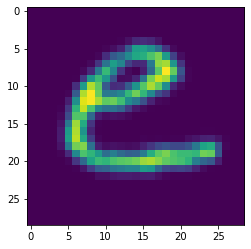

In [8]:
# build the test set    
raw_mnist_test = MnistRotDataset(mode='test')

# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

x = resize1(pad(x))

trans_x = []

for r in range(500):
    x_transformed = totensor(resize2(x.rotate(r * 360 / 500., Image.BILINEAR))).reshape(1, 1, 29, 29)
    x_transformed = x_transformed.to(device)
    trans_x.append(x_transformed)
trans_x = torch.cat(trans_x)
plt.imshow(trans_x[130, 0])
plt.show()

In [9]:
train_transform = Compose([pad, resize1, RandomRotation(180, expand=False), resize2, totensor, ])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

test_transform = Compose([pad, totensor, ])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

#test

b1s = []
b2s = []
b3s = []
b4s = []
b5s = []
b6s = []

card_list = [2, 4, 8, 16, 32]

for X, Y in train_loader:
    X = X
    T = Y
    break

## I.3 Train models

In [10]:
for card in card_list:
    print('Model with cardinality', card)
    model = SteerableCNN(card=card).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
    for epoch in range(31):
        model.train()
        print('Epoch:', epoch)
        for i, (x, t) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)

            y = model(x)[0]

            loss = loss_function(y, t)

            loss.backward()

            optimizer.step()

        if epoch % 10 == 0:
            total = 0
            correct = 0
            with torch.no_grad():
                model.eval()
                for i, (x, t) in enumerate(test_loader):
                    x = x.to(device)
                    t = t.to(device)

                    y = model(x)[0]

                    _, prediction = torch.max(y.data, 1)
                    total += t.shape[0]
                    correct += (prediction == t).sum().item()
            print(f"epoch {epoch} | test accuracy: {correct / total * 100.}")

    print('Model trained')
    model.eval()
    y = model(trans_x)[1]
    print('Model evaluated')

    y[0] = np.array([x.flatten() for x in y[0].tensor.detach().numpy()])
    y[0] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[0])

    y[1] = np.array([x.flatten() for x in y[1].tensor.detach().numpy()])
    y[1] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[1])

    y[2] = np.array([x.flatten() for x in y[2].tensor.detach().numpy()])
    y[2] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[2])

    y[3] = np.array([x.flatten() for x in y[3].tensor.detach().numpy()])
    y[3] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[3])

    y[4] = np.array([x.flatten() for x in y[4].tensor.detach().numpy()])
    y[4] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[4])

    y[5] = np.array([x.flatten() for x in y[5].tensor.detach().numpy()])
    y[5] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[5])

    b1s.append(y[0])
    b2s.append(y[1])
    b3s.append(y[2])
    b4s.append(y[3])
    b5s.append(y[4])
    b6s.append(y[5])

print('Model with SO(2)')
model = SO2SteerableCNN().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
for epoch in range(31):
    model.train()
    print('Epoch:', epoch)
    for i, (x, t) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)[0]

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

    if epoch % 10 == 0:
        total = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for i, (x, t) in enumerate(test_loader):
                x = x.to(device)
                t = t.to(device)

                y = model(x)[0]

                _, prediction = torch.max(y.data, 1)
                total += t.shape[0]
                correct += (prediction == t).sum().item()
        print(f"epoch {epoch} | test accuracy: {correct / total * 100.}")

model.eval()
print('Model trained')
y = model(trans_x)[1]

print('Saving layers')
y[0] = np.array([x.flatten() for x in y[0].tensor.detach().numpy()])
y[0] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[0])

y[1] = np.array([x.flatten() for x in y[1].tensor.detach().numpy()])
y[1] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[1])

y[2] = np.array([x.flatten() for x in y[2].tensor.detach().numpy()])
y[2] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[2])

y[3] = np.array([x.flatten() for x in y[3].tensor.detach().numpy()])
y[3] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[3])

y[4] = np.array([x.flatten() for x in y[4].tensor.detach().numpy()])
y[4] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[4])

y[5] = np.array([x.flatten() for x in y[5].tensor.detach().numpy()])
y[5] = sklearn.decomposition.PCA(n_components=10).fit_transform(y[5])

b1s.append(y[0])
b2s.append(y[1])
b3s.append(y[2])
b4s.append(y[3])
b5s.append(y[4])
b6s.append(y[5])

Model with cardinality 2
Epoch: 0
epoch 0 | test accuracy: 80.884
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
epoch 10 | test accuracy: 94.62
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
epoch 20 | test accuracy: 96.074
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
epoch 30 | test accuracy: 96.706
Model trained
Model evaluated
Model with cardinality 4
Epoch: 0
epoch 0 | test accuracy: 90.39399999999999
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
epoch 10 | test accuracy: 96.446
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
epoch 20 | test accuracy: 97.148
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
epoch 30 | test accuracy: 97.382
Model trained
Model evaluated
Model with cardina

KeyboardInterrupt: 

In [27]:
b1s = np.array(b1s)
b2s = np.array(b2s)
b3s = np.array(b3s)
b4s = np.array(b4s)
b5s = np.array(b5s)
b6s = np.array(b6s)

np.save("data/steerable_cnn_b1s.npy", b1s)
np.save("data/steerable_cnn_b2s.npy", b2s)
np.save("data/steerable_cnn_b3s.npy", b3s)
np.save("data/steerable_cnn_b4s.npy", b4s)
np.save("data/steerable_cnn_b5s.npy", b5s)
np.save("data/steerable_cnn_b6s.npy", b6s)

# II. Look for orbits

In [3]:
def MakeLiePCA():
    # Reduce dimension
    pca = sklearn.decomposition.PCA(n_components=ambient_dim)
    Y = pca.fit_transform(X)
    # Orthonormalize
    Y, Cov = orthonormalize(Y)
    Y = np.real(Y)
    Y /= np.mean([np.linalg.norm(p) for p in Y])
    # Lie-PCA
    Sigma = get_lie_pca_operator(Y, nb_neighbors=2, orbit_dim=1, method="PCA", verbose=True)
    return Sigma, Y, pca, Cov


def MakeLieDetect():
    # Select a candidate for initial point
    norms = [np.linalg.norm(p) for p in Y]
    norms_median = np.median(norms)
    i_initial = np.argmin(np.abs(norms - norms_median))
    # LieDetect
    dim = 1
    # Find frequencies
    OptimalFrequencies, OptimalLieAlgebra = find_closest_algebra('torus', Sigma, dim, frequency_max=frequency_max,
                                                                 method="abelian")
    # Generate estimated orbit
    n_points_orbit = 10000
    x = Y[i_initial, :]
    Orbit = sample_orbit_from_algebra('torus', OptimalFrequencies, OptimalLieAlgebra, nb_points=n_points_orbit, x=x,
                                      method='uniform')
    # Compute non-symmetric Hausdorff
    Hausdorff_1 = scipy.spatial.distance.directed_hausdorff(Y, Orbit)[0]
    print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff_1, 4))
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Y)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', round(Hausdorff, 4))
    return Orbit, OptimalFrequencies, Hausdorff_1

In [4]:
# Load trained models.
b1s = np.load('data/steerable_cnn_b1s.npy')
b2s = np.load('data/steerable_cnn_b2s.npy')
b3s = np.load('data/steerable_cnn_b3s.npy')
b4s = np.load('data/steerable_cnn_b4s.npy')
b5s = np.load('data/steerable_cnn_b5s.npy')
b6s = np.load('data/steerable_cnn_b6s.npy')

In [5]:
' Detect orbits of SO(2) '

hausdorff_distances_1 = []
hausdorff_distances_2 = []
hausdorff_distances_3 = []
hausdorff_distances_4 = []
hausdorff_distances_5 = []
hausdorff_distances_6 = []

ambient_dim = 8
frequency_max = 8

for i in range(b1s.shape[0]):
    print('Cardinality', i)

    # b1s
    X = b1s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_1.append(distance)

    # b2s
    X = b2s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_2.append(distance)

    # b3s
    X = b3s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_3.append(distance)

    # b4s
    X = b4s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_4.append(distance)

    # b5s
    X = b5s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_5.append(distance)

    # b6s
    X = b6s[i]
    X = np.array([x.flatten() for x in X])
    Sigma, Y, pca, Cov, = MakeLiePCA()
    Orbit, OptimalFrequencies, distance = MakeLieDetect()
    hausdorff_distances_6.append(distance)

Cardinality 0
Lie PCA first eigenvalues: 3.8e-04  3.7e-02  4.2e-02  6.6e-02  Eigengap #1: 9.6e+01.
----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 3, 4),) with cost 1.007e-03.
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0629
Non-symmetric Hausdorff distance from estimated orbit to X: 0.0651
Lie PCA first eigenvalues: 7.5e-04  3.4e-02  4.4e-02  6.8e-02  Eigengap #1: 4.6e+01.
----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 3, 4),) with cost 1.363e-03.
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0947
Non-symmetric Hausdorff distance from estimated orbit to X: 0.096
Lie PCA first eigenvalues: 2.8e-04  3.7e-02  4.0e-02  6.9e-02  Eigengap #1: 1.3e+02.
----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 3, 4),) with cost 4.076e-04.
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0361
Non-symmetric Hausdorf

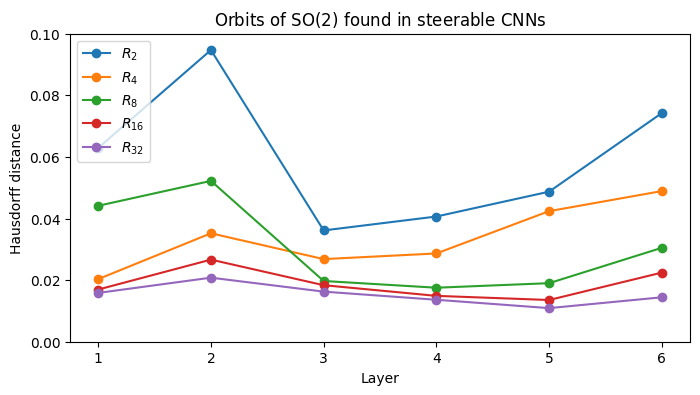

In [6]:
' Plot results '

fig = plt.figure(figsize=(8, 4))
plt.plot(range(1, 7),
         [hausdorff_distances_1[0], hausdorff_distances_2[0], hausdorff_distances_3[0], hausdorff_distances_4[0],
          hausdorff_distances_5[0], hausdorff_distances_6[0]], marker="o", label=r'$R_2$')
plt.plot(range(1, 7),
         [hausdorff_distances_1[1], hausdorff_distances_2[1], hausdorff_distances_3[1], hausdorff_distances_4[1],
          hausdorff_distances_5[1], hausdorff_distances_6[1]], marker="o", label=r'$R_4$')
plt.plot(range(1, 7),
         [hausdorff_distances_1[2], hausdorff_distances_2[2], hausdorff_distances_3[2], hausdorff_distances_4[2],
          hausdorff_distances_5[2], hausdorff_distances_6[2]], marker="o", label=r'$R_8$')
plt.plot(range(1, 7),
         [hausdorff_distances_1[3], hausdorff_distances_2[3], hausdorff_distances_3[3], hausdorff_distances_4[3],
          hausdorff_distances_5[3], hausdorff_distances_6[3]], marker="o", label=r'$R_{16}$')
plt.plot(range(1, 7),
         [hausdorff_distances_1[4], hausdorff_distances_2[4], hausdorff_distances_3[4], hausdorff_distances_4[4],
          hausdorff_distances_5[4], hausdorff_distances_6[4]], marker="o", label=r'$R_{32}$')
plt.legend(loc="upper left")

plt.xlabel('Layer')
plt.ylabel('Hausdorff distance')
plt.title(r'Orbits of $\mathrm{SO}(2)$ found in steerable CNNs')
plt.ylim(0, 0.1)
plt.show()
fig.savefig('figures/adult_layers.png', dpi=fig.dpi, bbox_inches='tight')